In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
exps = {
    # 'Text': 'w32a4-lut.text-0',
    # 'Vision': 'w32a4-lut.vision-0',
    'Hybrid': 'w32a4-lut.hybrid-0',
    'Split': 'w32a4-lut-1',
}
comps = ['self_attn.q_proj', 'self_attn.o_proj', 'mlp.up_proj', 'mlp.down_proj']

In [3]:
log_dir = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot/eval-logs'
header = ['outliers_rate', 'outliers', 'total_vals', 'in_err', 'out_err']

def load_logs(exp_name, layer, comp):
    return pd.read_csv(os.path.join(log_dir, exp_name, f'model.layers.{layer}.{comp}.txt'), names=header)

In [4]:
def merge_split_data(df: pd.DataFrame):
    return df[0::2].reset_index(drop=True) + df[1::2].reset_index(drop=True)

def calc_outlier_rate(df: pd.DataFrame):
    df['outliers_rate'] = df['outliers'] / df['total_vals']
    return df

In [5]:
def collect_data(df: pd.DataFrame):
    return (
        df['outliers'].astype(np.int64).sum() / df['total_vals'].astype(np.int64).sum(),
        df['in_err'].astype(np.float64).sum(),
        df['out_err'].astype(np.float64).sum(),
    )

In [6]:
def load_comp(layer: int, comp: str):
    data = {modal: load_logs(exp_name, layer, comp) for modal, exp_name in exps.items()}
    data['Split'] = merge_split_data(data['Split'])
    data = {modal: calc_outlier_rate(df) for modal, df in data.items()}
    return data

def plot_comp(ax: plt.Axes, data: dict[str, pd.DataFrame], cat: str):
    for modal, df in data.items():
        ax.plot(df[cat], label=modal)
    ax.legend()
    ax.set_ylabel(cat)

collected = {
    comp: {
        modal: {
            'outliers_rate': [],
            'in_err': [],
            'out_err': [],
        } for modal in exps
    } for comp in comps
}

print('Layers: ', end='')
for layer in range(32):
    print(f'{layer}, ', end='')
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0.3)
    for j, comp in enumerate(comps):
        data = load_comp(layer, comp)
        for modal, df in data.items():
            outliers_rate, in_err, out_err = collect_data(df)
            collected[comp][modal]['outliers_rate'].append(outliers_rate)
            collected[comp][modal]['in_err'].append(in_err)
            collected[comp][modal]['out_err'].append(out_err)
        ax = plt.subplot(4, 3, j * 3 + 1)
        plot_comp(ax, data, 'outliers_rate')
        ax.set_title(comp)
        if j == len(comps) - 1:
            ax.set_xlabel('batch_idx')
        ax = plt.subplot(4, 3, j * 3 + 2)
        plot_comp(ax, data, 'in_err')
        ax.set_title(comp)
        if j == len(comps) - 1:
            ax.set_xlabel('batch_idx')
        ax = plt.subplot(4, 3, j * 3 + 3)
        plot_comp(ax, data, 'out_err')
        ax.set_title(comp)
        if j == len(comps) - 1:
            ax.set_xlabel('batch_idx')
    plt.suptitle(f'Layer {layer}')
    plt.savefig(os.path.join(log_dir, 'img', f'layer-{layer:0>2}.png'))
    plt.close()

print(f'\nCollected: {collected}')

Layers: 0, 

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
Collected: {'self_attn.q_proj': {'Hybrid': {'outliers_rate': [0.015462213468728175, 0.02791933700562731, 0.045404549907330734, 0.048101875785564935, 0.04796424100385202, 0.049222442891936447, 0.049212640183727015, 0.052469974283529036, 0.05184955388360304, 0.05289074297972169, 0.05368716039881091, 0.055079352353534755, 0.05464384916716443, 0.055425075360798895, 0.05854611223558642, 0.05583544273433605, 0.05397914307448321, 0.0537367243915445, 0.05269479818660212, 0.0524339837975546, 0.05256207981426359, 0.05138638087449035, 0.05057370348209097, 0.05096694042682002, 0.0487707289527629, 0.04517439657982724, 0.04672076070142841, 0.04733678277659955, 0.04713367230976516, 0.04761037898382265, 0.045982976541315716, 0.04636151333739556], 'in_err': [142619.6178125143, 686294.8810021281, 1341454.281703174, 3514719.3301923275, 3047651.4631670117, 3273205.212949693, 5161701.77077120

/tmp/ipykernel_76838/2369667757.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


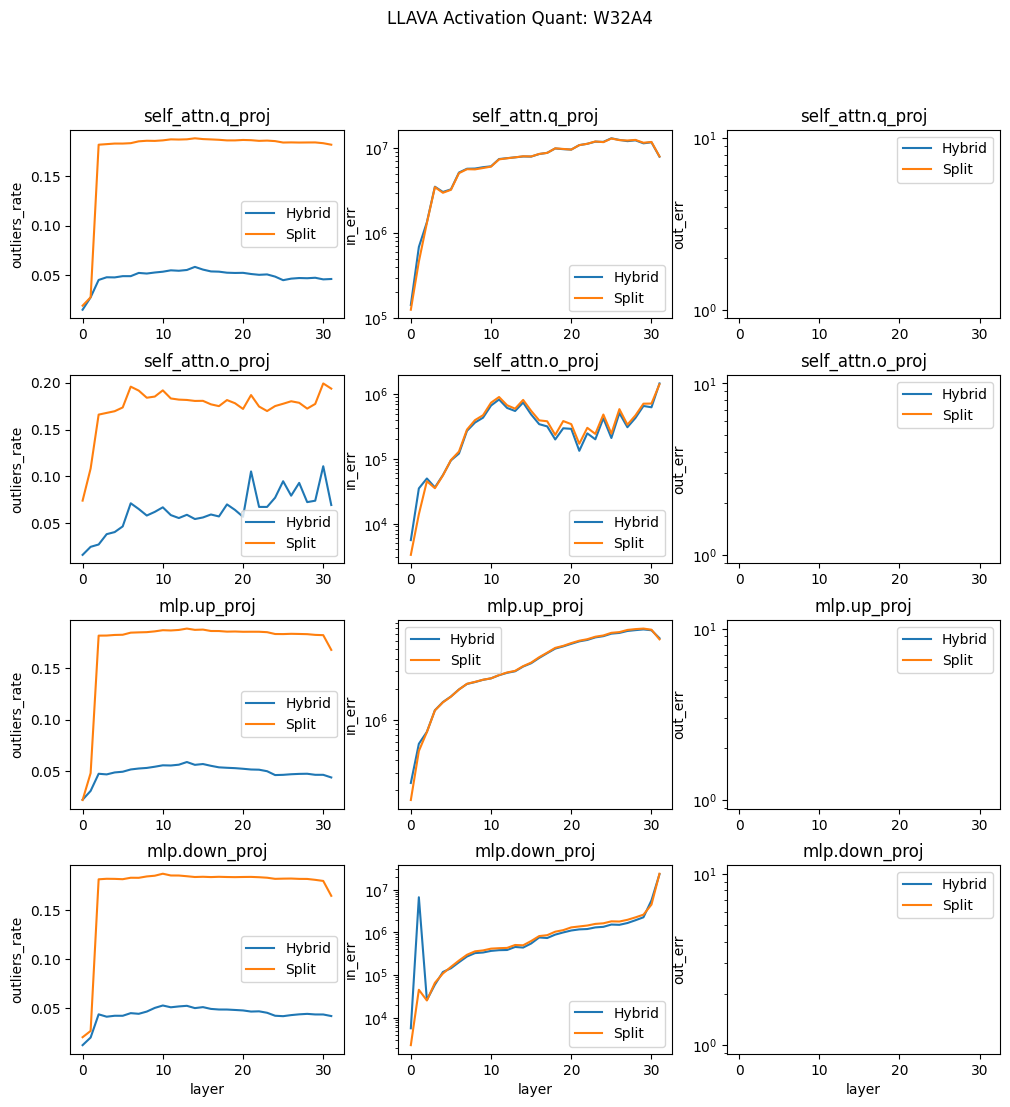

In [7]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.3)
for j, comp in enumerate(comps):
    ax = plt.subplot(4, 3, j * 3 + 1)
    plot_comp(ax, collected[comp], 'outliers_rate')
    if j == len(comps) - 1:
        ax.set_xlabel('layer')
    ax.set_title(comp)
    ax = plt.subplot(4, 3, j * 3 + 2)
    plot_comp(ax, collected[comp], 'in_err')
    ax.set_yscale('log')
    if j == len(comps) - 1:
        ax.set_xlabel('layer')
    ax.set_title(comp)
    ax = plt.subplot(4, 3, j * 3 + 3)
    plot_comp(ax, collected[comp], 'out_err')
    ax.set_yscale('log')
    if j == len(comps) - 1:
        ax.set_xlabel('layer')
    ax.set_title(comp)
plt.suptitle(f'LLAVA Activation Quant: W32A4')
plt.savefig(os.path.join(log_dir, 'img', f'w32a4.png'))